# Advanced ML: Теорема Байеса и линейная регрессия что делать с короновирусом 
**(Дедлайн 7 марта)**

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

## Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.express as px
from scipy.stats import multivariate_normal
from scipy.linalg import inv
import seaborn as sns


In [2]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 150})

## 01 Downloading

**Задание:**

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

Скачаем датасет

In [3]:
DATASET_PATH = "./owid-covid-data.csv"

In [4]:
# !curl -L https://covid.ourworldindata.org/data/owid-covid-data.csv -o $DATASET_PATH

In [5]:
covid_data = pd.read_csv(DATASET_PATH, sep=',')

In [6]:
rus_covid_data = covid_data[(covid_data['location']=="Russia") & (covid_data['date'] >= '2020-03-03')]

In [7]:
rus_covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
121025,RUS,Europe,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121026,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121027,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121028,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121029,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [8]:
rus_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 121025 to 121741
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    717 non-null    object 
 1   continent                                   717 non-null    object 
 2   location                                    717 non-null    object 
 3   date                                        717 non-null    object 
 4   total_cases                                 717 non-null    float64
 5   new_cases                                   717 non-null    float64
 6   new_cases_smoothed                          717 non-null    float64
 7   total_deaths                                701 non-null    float64
 8   new_deaths                                  701 non-null    float64
 9   new_deaths_smoothed                         701 non-null    float64
 10  total_

Заменим в признаке 'new_cases' нули на единицы.

In [9]:
rus_covid_data.loc[rus_covid_data['new_cases'] < 1., 'new_cases'] = 1.0

/Users/minakovaa/VSCodeProjects/venv-vscode/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Разобьем на train/test

In [10]:
target_columns = ['total_cases', 'new_cases']
feature_columns = set(rus_covid_data.columns).difference(set(target_columns))

In [11]:
X_train = rus_covid_data[feature_columns].iloc[:50]
y_train = rus_covid_data[target_columns].iloc[:50]

X_test = rus_covid_data[feature_columns].iloc[50:]
y_test = rus_covid_data[target_columns].iloc[50:]

print(f"Train: {X_train.shape},  {y_train.shape} \nTest : {X_test.shape}, {y_test.shape}")

Train: (50, 65),  (50, 2) 
Test : (667, 65), (667, 2)


## 02 Exponential law

**Задание**: 

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

1. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

1. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

1. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


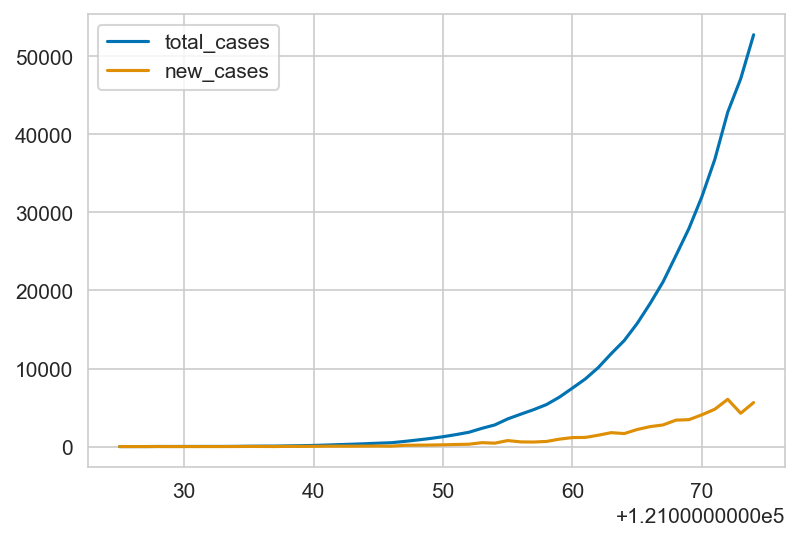

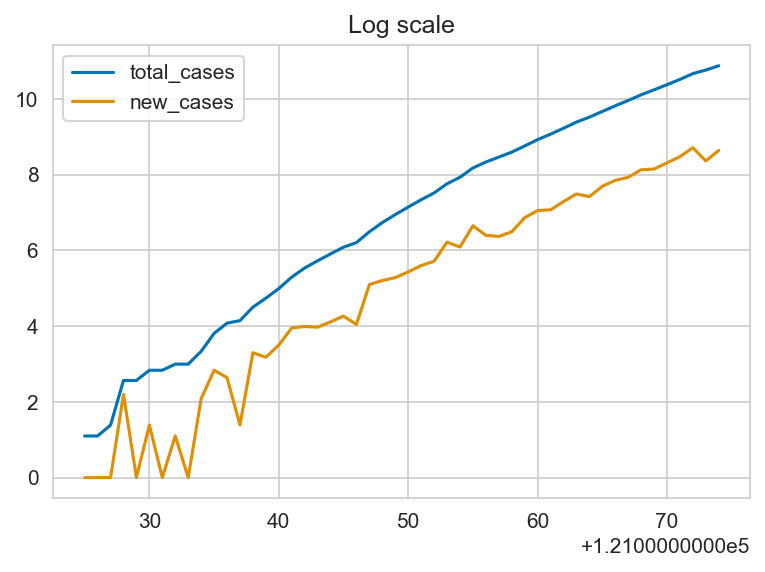

In [12]:
y_train.plot();
np.log(y_train).plot(title='Log scale');

Добавим номер текущего дня в качестве фичи.

In [13]:
def get_n_days(df_date, start_date='2020-03-03'):
    return (df_date.apply(pd.to_datetime) - pd.to_datetime(start_date)).dt.days + 1

In [14]:
X_train['n_days'] = get_n_days(X_train['date'], start_date='2020-03-03')
X_test['n_days'] = get_n_days(X_test['date'], start_date='2020-03-03')

Обучим модель линейной регрессии.

In [15]:
X_train_n_days = X_train['n_days'].to_numpy().reshape(-1,1)
log_y_train = np.log(y_train.to_numpy())

lin_reg = LinearRegression().fit(X_train_n_days, log_y_train)

In [16]:

X_test_n_days = X_test['n_days'].to_numpy().reshape(-1,1)
log_y_test = np.log(y_test.to_numpy())

y_predict = lin_reg.predict(X_test_n_days)
y_predict = np.exp(y_predict)

In [17]:
y_predict = pd.DataFrame(y_predict, columns=map(lambda s: s + '_predicted', target_columns), index=X_test['n_days'])
y_test = y_test.set_index(X_test['n_days'])

In [18]:
y_predict

,total_cases_predicted,new_cases_predicted
n_days,,
51,1.249018e+05,1.504562e+04
52,1.522948e+05,1.812061e+04
53,1.856957e+05,2.182406e+04
54,2.264219e+05,2.628441e+04
55,2.760801e+05,3.165636e+04
...,...,...
713,1.275822e+62,4.388812e+57
714,1.555632e+62,5.285787e+57
715,1.896809e+62,6.366085e+57


Постром графики целевыx переменных в зависимости от номера дня:

In [19]:
fig_1 = px.line(y_predict)
fig_2 = px.line(y_test)

fig_1.show()
fig_2.show()

Предсказанные значения слишком быстро растут, поэтому рассмотрим график в логарифмической шкале для целевых перемнных

In [20]:
fig = px.line(pd.concat([y_predict.apply(np.log), y_test.apply(np.log)], axis=1), title="Plot in log scale")
fig.show()


 Найдем апостериорное распределение параметров модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Априорное распределение $p(w) = \mathcal{N}\left(w |\mu_0, \Sigma_0\right)$,
где $\mu_0 = \begin{pmatrix} 0, & 0 \end{pmatrix}$, и $\Sigma_0 = \begin{pmatrix} 1/\alpha & 0\\ 0 & 1/\alpha \end{pmatrix}$

In [21]:
alpha = 1 # select alpha

mu_0, sigma_0 = np.array([0, 0]), (1/alpha) * np.array([[1, 0], [0, 1]])
apriop_distr = multivariate_normal(mean=mu_0, cov=sigma_0) # to run: apriop_distr.pdf(X_train_n_days)

Оценим дисперсию шума 
$$\sigma^2 = \frac{1}{N} \sum_{n=1}^{N}(y_n - w^T_{ML}x_n),$$
где 
$$w_{ML} = (\Phi^T \Phi)^{-1} \Phi^T \mathbf{y}$$
и
$$\Phi = X$$

In [22]:
# Добавим единицы в множество признаков для свободного члена 
X_train = np.hstack((np.ones(len(X_train_n_days))[:, np.newaxis], X_train_n_days))

#X_train = X_train_n_days

$w_{ML}$:

In [23]:
is_total_or_new_cases = 0 # 0 if total, 1 if new
X, log_y = X_train, log_y_train[:, 0]
w_ML = inv(X.T @ X) @ X.T @ log_y
w_ML # Для общего количества или для новых случаев

array([1.62244624, 0.19829091])

$\sigma^2_{ML}: $

In [24]:
sig_2_ML = (1/len(X)) * np.sum((log_y -  X @ w_ML) ** 2, axis=0)
sig_2_ML # Для общего количества или для новых случаев

0.12183046154391233

Полагаем, что данные независимы и одинаково распределены:
 $$p(\mathbf{y}|X, w, σ^2)=\prod_{n=1}^{N} \mathcal{N}(\mathbf{y_n}|w^T x_n, σ^2)$$

Нужно посчитать
$$p(w|\mathbf{y}) \propto p(\mathbf{y}|X, w, σ^2) p(w) = \mathcal{N}\left(w | \mu_0, \Sigma_0 \right) \prod_{n=1}^{N} \mathcal{N}(\mathbf{y_n}|w^T x_n, σ^2)$$

Получаем
$$p(w|\mathbf{y}) = \mathcal{N}\left(w | \mu_N, \Sigma_N \right),$$

где $$\mu_N = \Sigma_N \left(\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2}\Phi^T\mathcal{y}\right)$$

и $$\Sigma_N=\left(\Sigma_0^{-1} + \frac{1}{\sigma^2}\Phi^T\Phi\right)$$

Тогда:

In [25]:
sigma_N = inv(inv(sigma_0) + ((1 / sig_2_ML)) * X.T @ X)
sigma_N

array([[ 9.94481545e-03, -2.95389720e-04],
       [-2.95389720e-04,  1.16121360e-05]])

In [26]:
mu_N = sigma_N @ (inv(sigma_0) @ mu_0 + (1 / sig_2_ML) * X.T @ log_y)
mu_N

array([1.60636988, 0.19876786])

Просемплируем разные экспоненнты и построим графики на тренировочных данных:

In [27]:
def myplot_sample_lines(mu, sigma, points, n=20, title=None, weights=None):
    
    if weights is None:
        # Посэмплируем и порисуем прямые
        weights = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    min_x, max_x = min(points[0]), max(points[0])
    min_y, max_y = min(points[1]), max(points[1])

    xs = np.linspace(min_x, max_x, 100)
    if title:
        plt.title(title)
        
    for w in weights:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.05)
    plt.ylim((min_y, max_y ))
    plt.xlim((min_x, max_x))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=20)

    return weights

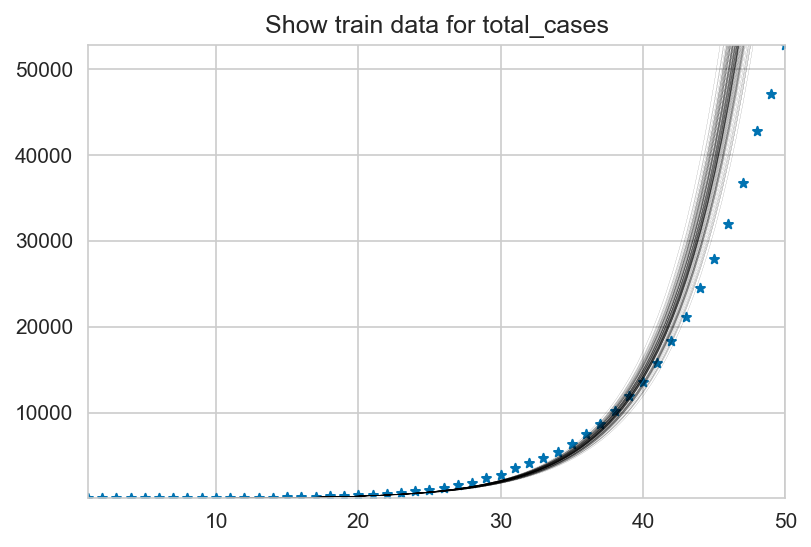

In [28]:
samles_weights = myplot_sample_lines(mu_N, sigma_N, points=[X[:, 1],  np.exp(log_y)], n=100, title="Show train data for total_cases")

И для тестовых данных

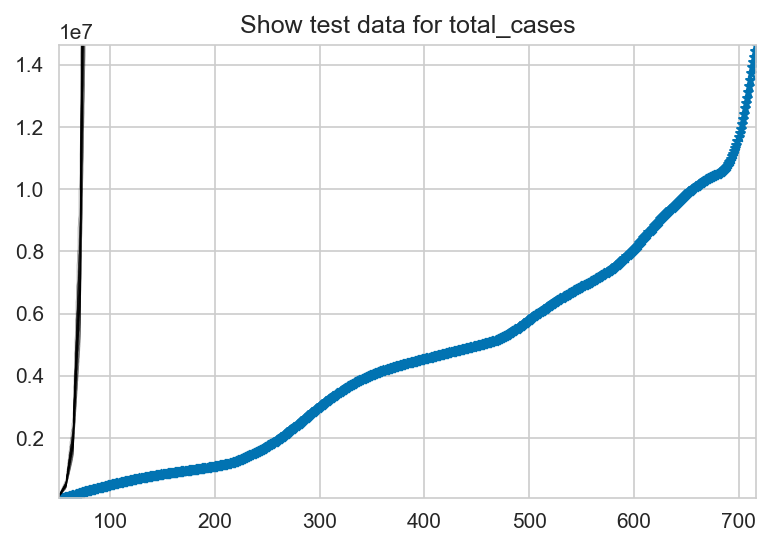

In [29]:
X, log_y = X_test_n_days.reshape(-1), log_y_test[:, is_total_or_new_cases]

samles_weights = myplot_sample_lines(mu_N, sigma_N, points=[X, np.exp(log_y)], title="Show test data for total_cases", weights=samles_weights)

Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [30]:

n_day = {}
n_day['01_may'] = int(X_test.loc[(X_test['date'] == '2020-05-01')].n_days)
n_day['01_jun'] = int(X_test.loc[(X_test['date'] == '2020-06-01')].n_days)
n_day['01_sep'] = int(X_test.loc[(X_test['date'] == '2020-09-01')].n_days)

Prediction for some days:


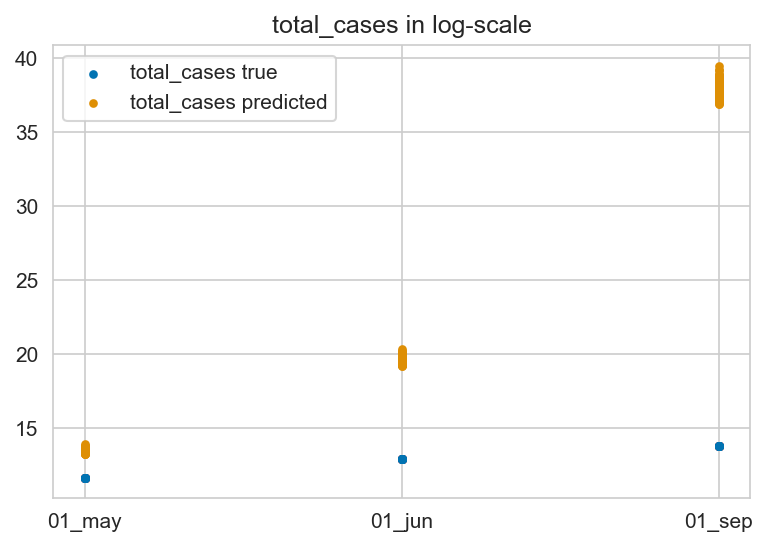

In [31]:
from collections import defaultdict

print("Prediction for some days:")
y_true, y_pred = [], []
plot_pred = defaultdict(list)
for w in samles_weights:
    for date, day in n_day.items():
        y_true.append(int(y_test.loc[day]['total_cases']))
        y_pred.append(np.exp(w[0] + w[1]*day))
        plot_pred[date].append(y_pred[-1])
        # print(F"For {date} true total_cases = {y_true[-1]} predict = {int(y_pred[-1])}")

plt.scatter(list(n_day.keys()) * samles_weights.shape[0], np.log(y_true), s=10) 
plt.scatter(list(n_day.keys()) * samles_weights.shape[0], np.log(y_pred), s=10) 
plt.title("total_cases in log-scale")
plt.legend(['total_cases true', 'total_cases predicted'])

plt.show()

Distribution total_cases in log-scale


<AxesSubplot:>

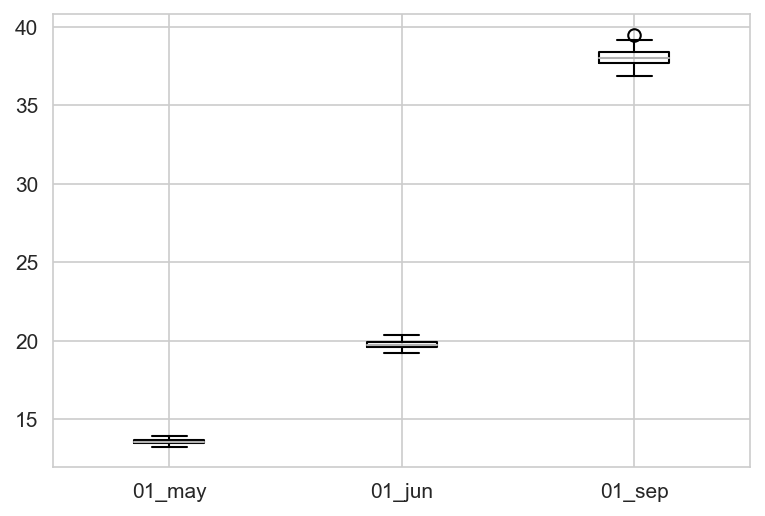

In [32]:
plot_log_pred = np.log(pd.DataFrame(plot_pred))
print("Distribution total_cases in log-scale")
plot_log_pred.boxplot()

Построим аналогичные предсказания для `new_cases`

In [33]:
is_total_or_new_cases = 1 # 0 if total_cases, 1 if new_cases

# select params
alpha = 1 # select alpha
X_train = np.hstack((np.ones(len(X_train_n_days))[:, np.newaxis], X_train_n_days))

X, log_y = X_train, log_y_train[:, is_total_or_new_cases]

# count values
mu_0, sigma_0 = np.array([0, 0]), (1 / alpha) * np.array([[1, 0], [0, 1]])
apriop_distr = multivariate_normal(mean=mu_0, cov=sigma_0) # to run: apriop_distr.pdf(X_train_n_days)


w_ML = inv(X.T @ X) @ X.T @ log_y
sig_2_ML = (1/len(X)) * np.sum((log_y -  X @ w_ML) ** 2, axis=0)
print(f"sig_2_ML=\n{sig_2_ML}")

sigma_N = inv(inv(sigma_0) + ((1 / sig_2_ML)) * X.T @ X)
mu_N = sigma_N @ (inv(sigma_0) @ mu_0 + (1 / sig_2_ML) * X.T @ log_y)

print(f"mu_N=\n{mu_N}, \n\nsigma_N=\n{sigma_N}")

sig_2_ML=
0.35530904878113967
mu_N=
[0.13104732 0.18607077], 

sigma_N=
[[ 2.84603896e-02 -8.45351109e-04]
 [-8.45351109e-04  3.33866010e-05]]


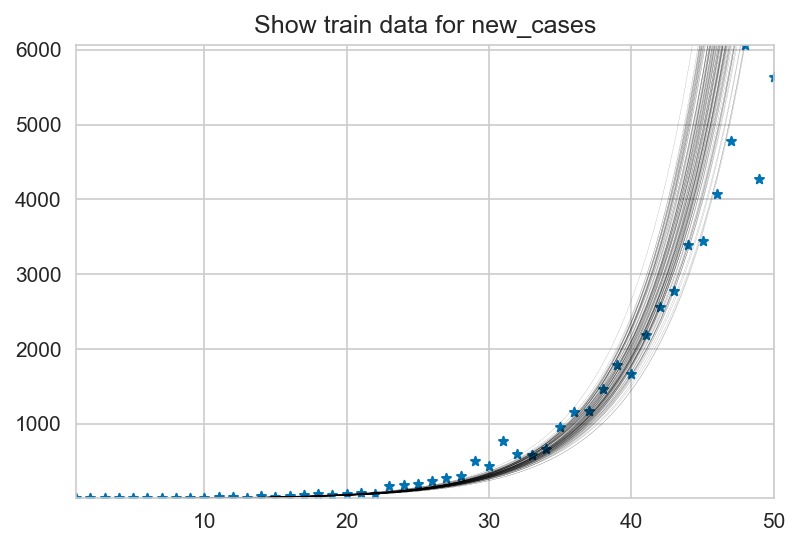

In [34]:
samles_weights = myplot_sample_lines(mu_N, sigma_N, points=[X[:, 1],  np.exp(log_y)], n=100, title="Show train data for new_cases")

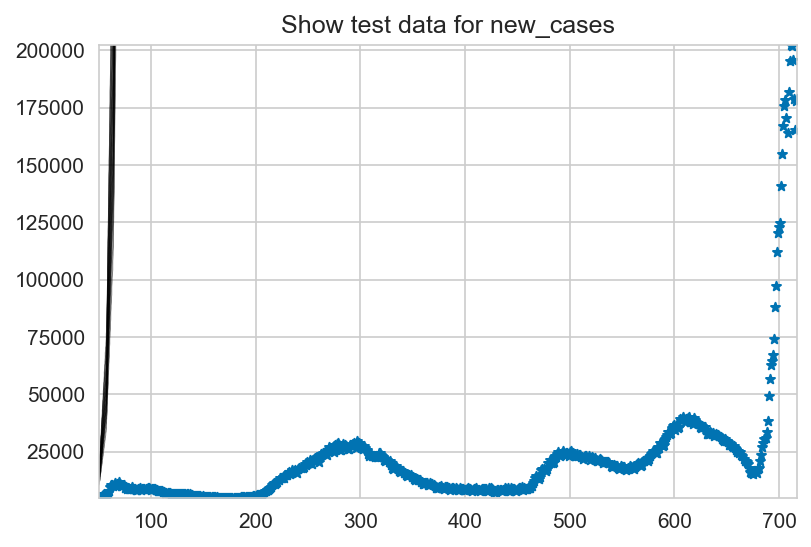

In [35]:
X, log_y = X_test_n_days.reshape(-1), log_y_test[:, is_total_or_new_cases]

samles_weights = myplot_sample_lines(mu_N, sigma_N, points=[X, np.exp(log_y)], title="Show test data for new_cases", weights=samles_weights)

Prediction for some days:


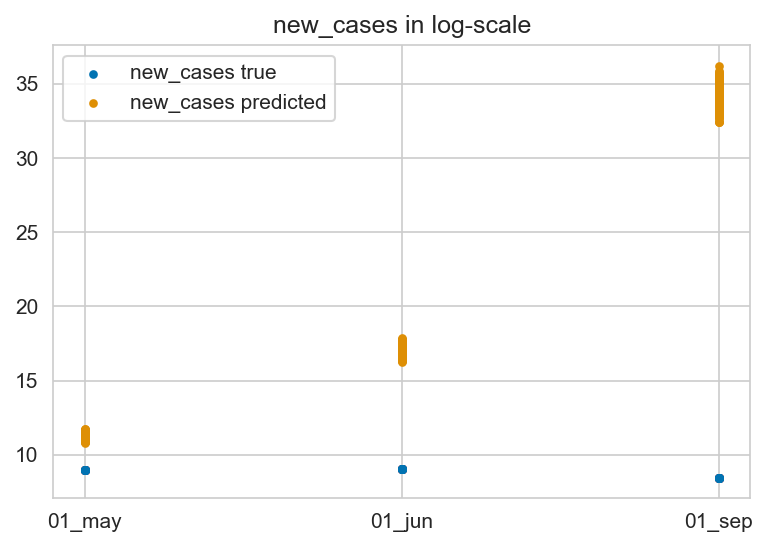

In [36]:

print("Prediction for some days:")
y_true, y_pred = [], []
plot_pred = defaultdict(list)
for w in samles_weights:
    for date, day in n_day.items():
        y_true.append(int(y_test.loc[day]['new_cases']))
        y_pred.append(np.exp(w[0] + w[1]*day))
        plot_pred[date].append(y_pred[-1])
        # print(F"For {date} true total_cases = {y_true[-1]} predict = {int(y_pred[-1])}")

plt.scatter(list(n_day.keys()) * samles_weights.shape[0], np.log(y_true), s=10) 
plt.scatter(list(n_day.keys()) * samles_weights.shape[0], np.log(y_pred), s=10) 
plt.title("new_cases in log-scale")
plt.legend(['new_cases true', 'new_cases predicted'])

plt.show()

Distribution new_cases in log-scale


<AxesSubplot:>

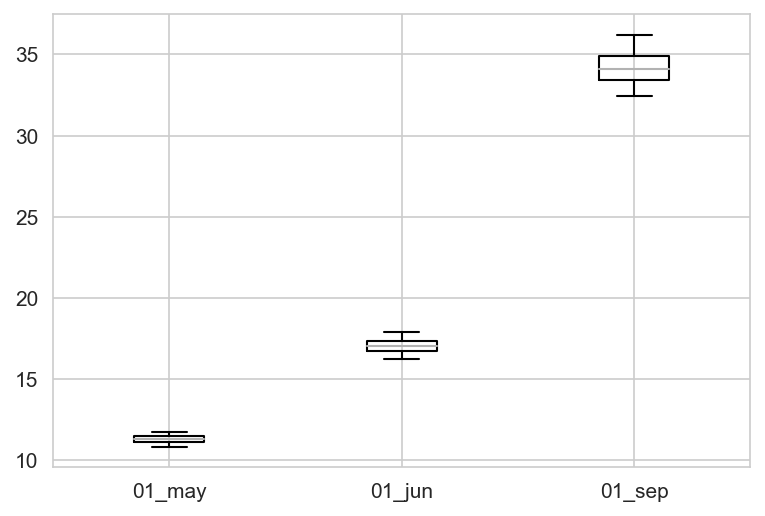

In [37]:
plot_log_pred = np.log(pd.DataFrame(plot_pred))
print("Distribution new_cases in log-scale")
plot_log_pred.boxplot()

## 03 Sigmoid law

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\Phi\left(x\right) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x}e^{-t^2/2}dt$$

![gaussian](gaussian.png)

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от $t$.

1. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

1. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

1. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?


Заметим, что для интеграла от экспоненты с произвольной квадратичной функции от $t$ (при $A > 0$)

$$f(x) = \int_{-\infty}^{x}e^{-(At^2+Bt+C)}dt = e^{\frac{B^2}{4 A} + C}  \int_{-\infty}^{x}e^{-\frac{(t - B/(2A))^2}{1/A}}dt = \frac{\sqrt{2\pi} e^{\frac{B^2}{4 A} + C} }{\sqrt{A}} \Phi\left(\frac{x-B/(2A)}{1/\sqrt{A}}\right),$$


Обозначим нормировочную константу перед интегралом 
$$K = \frac{\sqrt{2\pi} e^{\frac{B^2}{4 A} + C} }{\sqrt{A}},$$

и обозначим $$\mu = B/(2A)$$ и $$\sigma=1/\sqrt{A}$$

тогда

$$f(x) = K \cdot \Phi\left(\frac{x-\mu}{\sigma}\right),$$

Тогда $$y = K \cdot \Phi_{\mu, \sigma^2}\left(x\right)=K \cdot \Phi\left(\frac{x-\mu}{\sigma}\right) $$
$$\Phi^{-1}\left(\frac{y}{K}\right) = \frac{x - \mu}{\sigma} $$

И при обучении линейной регрессии
$$\Phi^{-1}\left(\frac{y}{K}\right) = w_0 + w_1 \cdot x$$
$\mu$ и $\sigma$ выражаются через параметры $w_0$ и $w_1$ следующим образом:
$$\mu = -\frac{w_0}{w_1}$$
$$ \sigma = \frac{1}{w_1}.$$

и будем произвольно выбирать константу $K$ из равномерного с левой границей равной максимальному значению из тренировочного набора данных и правой границей равной количеству граждан России (144 миллиона человек)

Попробуем например для $K = 20000000$

In [38]:
from scipy.stats import norm

total_or_new_cases = 'total_cases' 
# X_train = np.hstack((np.ones(len(X_train_n_days))[:, np.newaxis], X_train_n_days))

K = 20_000_000
norm_ppf_y_train = norm.ppf(y_train[total_or_new_cases].to_numpy() / K)

lin_reg = LinearRegression().fit(X_train_n_days, norm_ppf_y_train)

y_predict_train = lin_reg.predict(X_train_n_days)
y_predict_train = norm.cdf(y_predict_train) * K

score_k = lin_reg.score(X_train_n_days, y_predict_train) #lin_reg.score(X_test_n_days, y_predict_test)

# Предскажем на тестовых данных
norm_ppf_y_test = norm.ppf(y_test[total_or_new_cases].to_numpy() / K)

y_predict_test = lin_reg.predict(X_test_n_days)
y_predict_test = norm.cdf(y_predict_test) * K


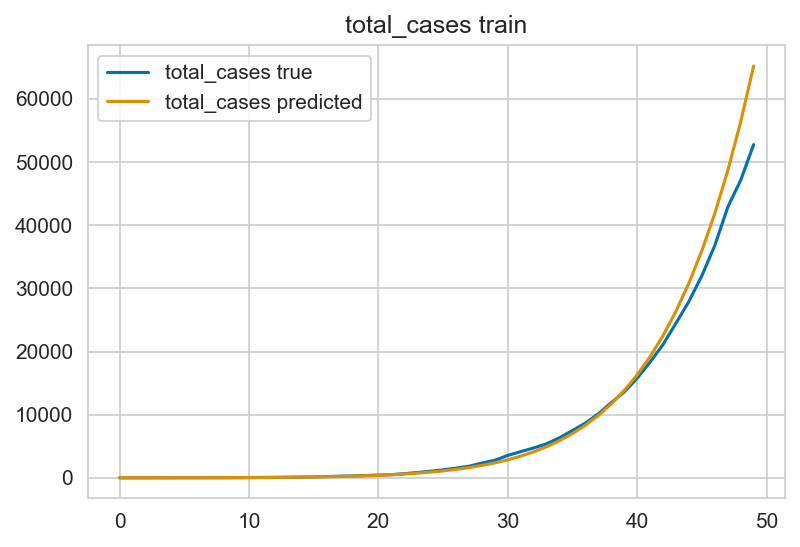

In [39]:
plt.plot(y_train[total_or_new_cases].to_numpy())
plt.plot(y_predict_train)
plt.title(total_or_new_cases+" train")
plt.legend([total_or_new_cases+' true', total_or_new_cases+' predicted'])

plt.show()

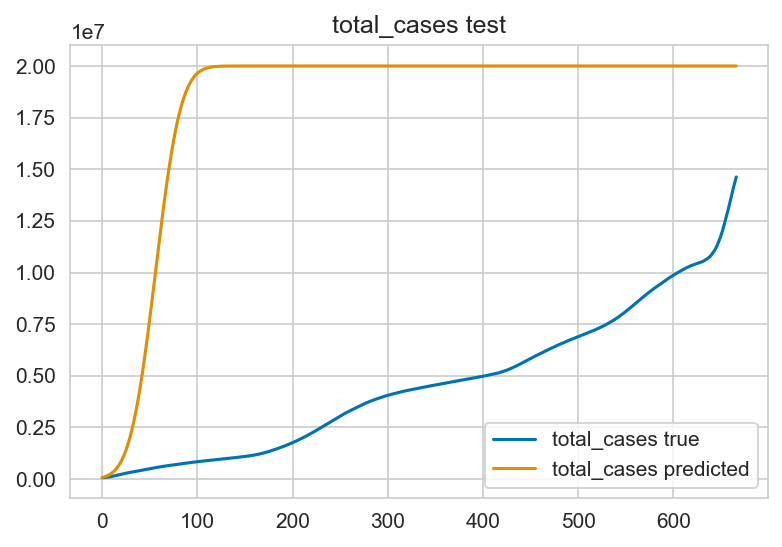

In [40]:
plt.plot(y_test[total_or_new_cases].to_numpy())
plt.plot(y_predict_test)
plt.title(total_or_new_cases+" test")
plt.legend([total_or_new_cases+' true', total_or_new_cases+' predicted'])

plt.show()

Для построения априорного распределения будем выбирать константу $K$ из равномерного от максимального числа зоболевших из тестового набора до $144000000$

In [41]:
def prior_dist(K):
    # count values
    norm_ppf_y_train = norm.ppf(y_train[total_or_new_cases].to_numpy() / K)

    # select params
    alpha = 1 # select alpha
    X_train = np.hstack((np.ones(len(X_train_n_days))[:, np.newaxis], X_train_n_days))

    X, norm_ppf_y = X_train, norm_ppf_y_train
    
    mu_0, sigma_0 = np.array([0, 0]), (1 / alpha) * np.array([[1, 0], [0, 1]])

    w_ML = inv(X.T @ X) @ X.T @ norm_ppf_y
    sig_2_ML = (1/len(X)) * np.sum((norm_ppf_y -  X @ w_ML) ** 2, axis=0)
    # print(f"sig_2_ML=\n{sig_2_ML}")

    sigma_N = inv(inv(sigma_0) + ((1 / sig_2_ML)) * X.T @ X)
    mu_N = sigma_N @ (inv(sigma_0) @ mu_0 + (1 / sig_2_ML) * X.T @ norm_ppf_y)

    # print(f"mu_N=\n{mu_N}, \n\nsigma_N=\n{sigma_N}")
    return mu_N, sigma_N

In [42]:
def myplot_sample_lines_sigmoid(mu, sigma, points, n=500, title=None, weights=None, K_s=None):
    
    if weights is None:
        min_K = max(y_train[total_or_new_cases])
        max_K = 144_000_000
        K_s = min_K + np.random.rand(n) * (max_K - min_K)

        weights = np.zeros((n, 2))
        for i, k in enumerate(K_s):
            mu, sigma = prior_dist(k)
            weights[i] = np.random.multivariate_normal(mu, sigma)

    min_x, max_x = min(points[0]), max(points[0])

    xs = np.linspace(min_x, max_x, 100)
    if title:
        plt.title(title)
        
    for w, k in zip(weights, K_s):
        plt.plot(xs, k * norm.cdf(w[0] + w[1]*xs), 'k-', lw=.05)
    if not points is None:
        plt.scatter(points[0],  points[1], marker='*', s=20)

    return weights, K_s

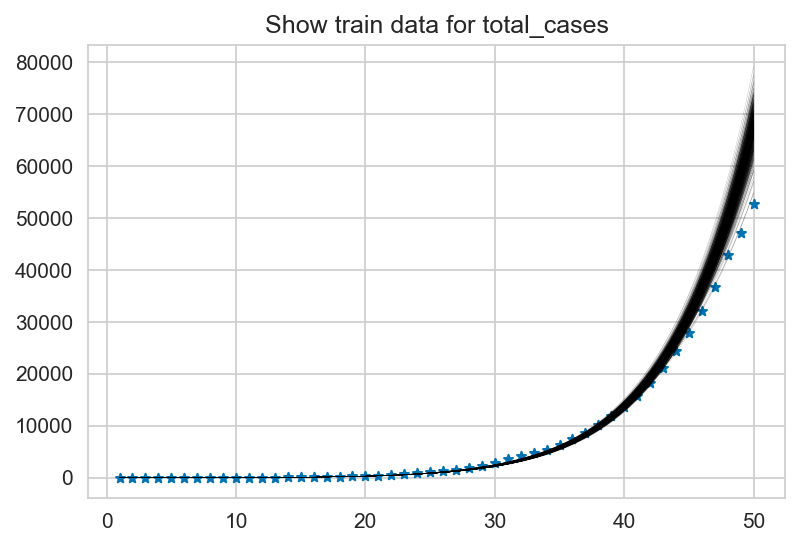

In [43]:
X_train = np.hstack((np.ones(len(X_train_n_days))[:, np.newaxis], X_train_n_days))

samles_weights, sample_K_s = myplot_sample_lines_sigmoid(mu_N, sigma_N, points=[X_train[:, 1],  y_train[total_or_new_cases].to_numpy()], n=500, title="Show train data for total_cases")

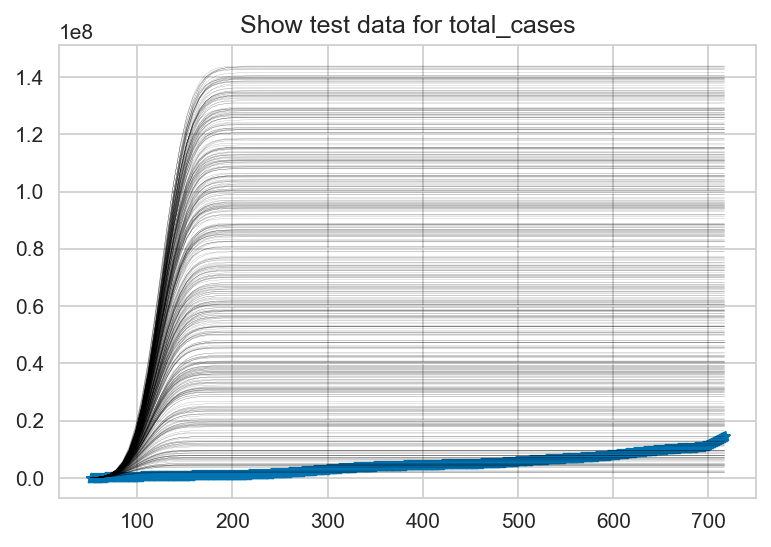

In [44]:
X_test = np.hstack((np.ones(len(X_test_n_days))[:, np.newaxis], X_test_n_days))

samles_weights, sample_K_s = myplot_sample_lines_sigmoid(mu_N, sigma_N, points=[X_test[:, 1],  y_test[total_or_new_cases].to_numpy()], n=100, title="Show test data for total_cases", weights=samles_weights, K_s=sample_K_s)

Prediction for some days:


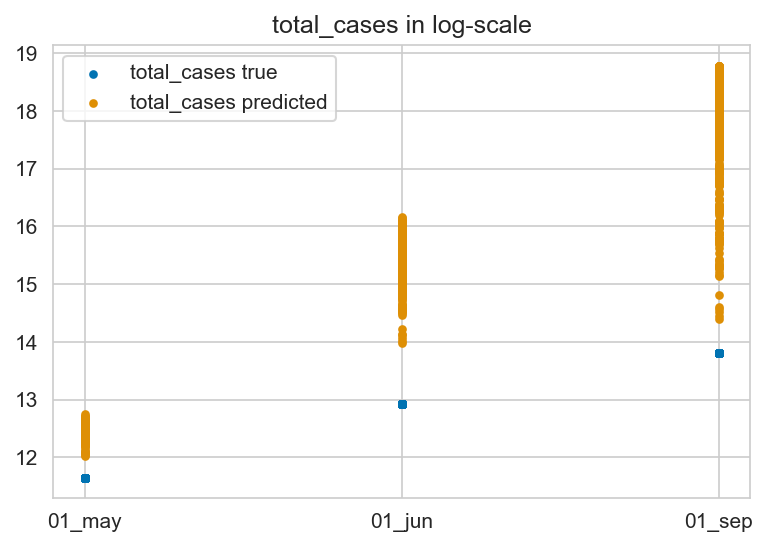

In [45]:
from collections import defaultdict

print("Prediction for some days:")
y_true, y_pred = [], []
plot_pred = defaultdict(list)
for w, k in zip(samles_weights, sample_K_s):
    for date, day in n_day.items():
        y_true.append(int(y_test.loc[day]['total_cases']))
        y_pred.append(k * norm.cdf(w[0] + w[1]*day))
        plot_pred[date].append(y_pred[-1])
        # print(F"For {date} true total_cases = {y_true[-1]} predict = {int(y_pred[-1])}")

plt.scatter(list(n_day.keys()) * samles_weights.shape[0], np.log(y_true), s=10) 
plt.scatter(list(n_day.keys()) * samles_weights.shape[0], np.log(y_pred), s=10) 
plt.title("total_cases in log-scale")
plt.legend(['total_cases true', 'total_cases predicted'])

plt.show()

Distribution new_cases in log-scale


<AxesSubplot:>

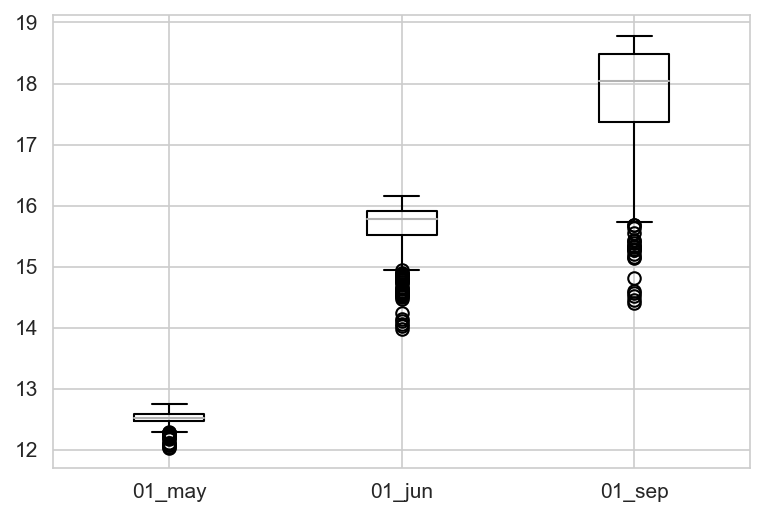

In [46]:
plot_log_pred = np.log(pd.DataFrame(plot_pred))
print("Distribution new_cases in log-scale")
plot_log_pred.boxplot()


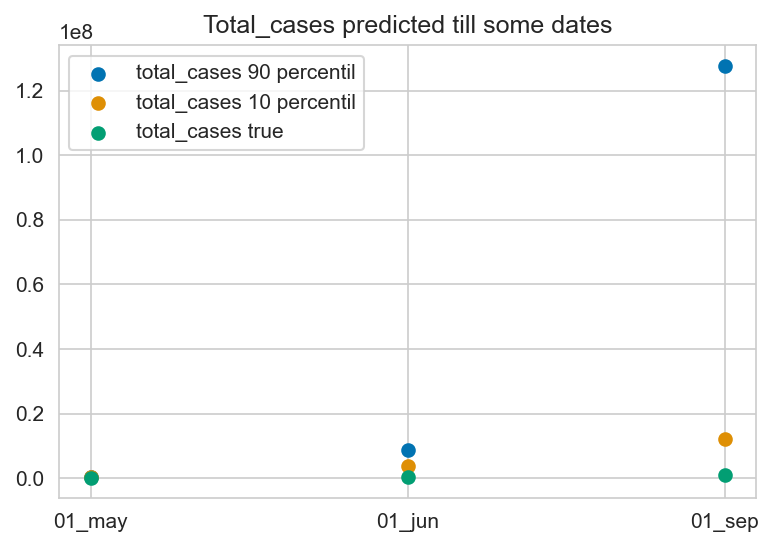

In [47]:
plot_pred = pd.DataFrame(plot_pred)
y_true_3_days  = y_test.loc[n_day.values(), 'total_cases'].values

plt.scatter(plot_pred.keys(), plot_pred.quantile(0.9).apply(int))
plt.scatter(plot_pred.keys(), plot_pred.quantile(0.1).apply(int))
plt.scatter(plot_pred.keys(), y_true_3_days)

plt.title("Total_cases predicted till some dates")
plt.legend(['total_cases 90 percentil', 'total_cases 10 percentil', 'total_cases true'])

plt.show()